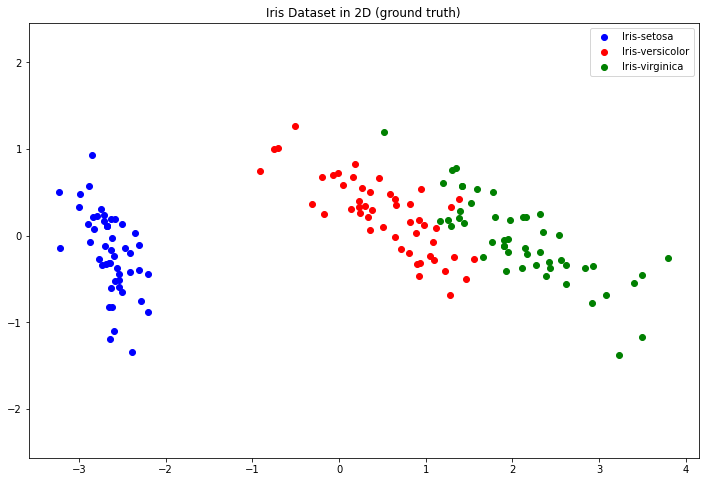

In [1]:
#Importing all the packages required
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Circle
from sklearn import metrics
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

#Reading the iris data and spliting them into data and targets
iris = pd.read_csv('iris.data', header=None)
train_data = iris.iloc[:,0:-1]
train_target = iris.iloc[:,-1]
#Function PCA used to get the most useful data for clustering
def PCA(X,PC):
    mean = X.mean(0)
    A = X-mean
    u,s,vt = np.linalg.svd(A, full_matrices=True)
    return vt
#Two of most important dimensions for identifying are the top two rows of vt
x_y = np.dot(train_data-train_data.mean(0),PCA(train_data,1)[0:2,:].T)
#The labels are going to be assigned a number and plotted on a graph
y_number = np.array([], dtype=np.int8)
plt.figure(figsize=(12,8))
for i in range(0,len(train_target)):
    if train_target.unique()[0]==train_target[i]:
        setosa = plt.scatter(x_y[i,0],x_y[i,1],c='b')
        y_number = np.append(y_number,2)
    if train_target.unique()[1]==train_target[i]:
        versicolor = plt.scatter(x_y[i,0],x_y[i,1],c='r')
        y_number = np.append(y_number,0)
    if train_target.unique()[2]==train_target[i]:
        virginica = plt.scatter(x_y[i,0],x_y[i,1],c='g')
        y_number = np.append(y_number,1)
plt.axis('equal')
plt.title('Iris Dataset in 2D (ground truth)')
plt.legend((setosa,versicolor,virginica),(train_target.unique()))
plt.show()

The accuracy for k mean is 88.66666666666667 %


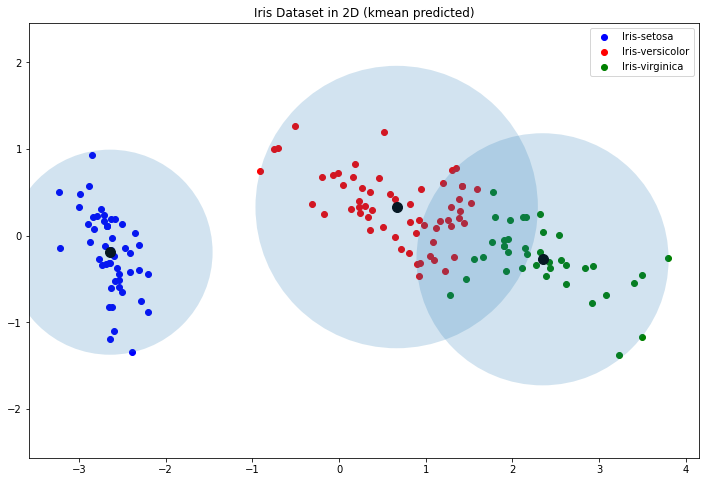

In [2]:
#This function gets the outermost point from the cluster and works out its radius
def getRadius(center,j):
    radius =0
    for i in range(len(relabel)):
        if j==relabel[i]:
            r = np.linalg.norm(x_y[i]-center)
            if r>=radius:
                radius = r
    return radius

#fit K mean clustering and setting 3 clusters as initial value
kmean_initial = KMeans(n_clusters=3).fit(x_y)
label = kmean_initial.labels_
relabel = label.copy()
centers = kmean_initial.cluster_centers_
recenters = centers.copy()
#Order of the centers by distance from origin (0,0)
center_ordered = np.argsort(np.argsort(np.linalg.norm(centers,axis=1)))

#The labels are relabeled with numbers easier to work averages with
for i in range(len(label)):
    for j in range(3):
        if center_ordered[j]!=j:
            if label[i]==j:
                relabel[i]=center_ordered[j]
#The centers are also reordered to match the relabels
for i in range(3):
    if center_ordered[i]!=i:
        recenters[center_ordered[i]]=centers[i]

#Plot all the points with it's predicted cluster assignment
ax = plt.figure(figsize=(12,8))
for i in range(len(label)):
    if relabel[i] == 0:
        versicolor = plt.scatter(x_y[i,0],x_y[i,1],c='r')
    if relabel[i] == 1:
        virginica = plt.scatter(x_y[i,0],x_y[i,1],c='g')
    if relabel[i] == 2:
        setosa = plt.scatter(x_y[i,0],x_y[i,1],c='b')

#Plot the centers of the clusters and circles using radius=furthest distance from cluster centers
ax = plt.scatter(recenters[:,0],recenters[:,1],c='k',s=100)
ax = plt.axis('equal')
ax = plt.gca()
for i in range(len(recenters[:,0])):
    ax.add_patch(Circle(recenters[i,:],radius=getRadius(recenters[i,:],i), alpha=1/5))

#Score assigned to work out the accuracy of kmean compared to the ground truth
score = 0
for i in range(len(y_number)):
    if y_number[i] == relabel[i]:
        score+=1

print('The accuracy for k mean is',100*score/len(y_number),'%')

plt.legend((setosa,versicolor,virginica),(train_target.unique()))
plt.title('Iris Dataset in 2D (kmean predicted)')
plt.show()

pi0: 0.30947121134728545
pi1: 0.35719545531939234
pi2: 0.33333333333332227
mu_0: [0.50957573 0.22506105]
mu_1: [ 2.02292953 -0.01719861]
mu_2: [-2.64084076 -0.19051995]
sigma_0:
 [[ 0.36455711 -0.21780862]
 [-0.21780862  0.18811298]]
sigma_1:
 [[ 0.5631686  -0.2932121 ]
 [-0.2932121   0.23224853]]
sigma_2:
 [[ 0.04777048 -0.05590782]
 [-0.05590782  0.21472356]]
total steps:  20


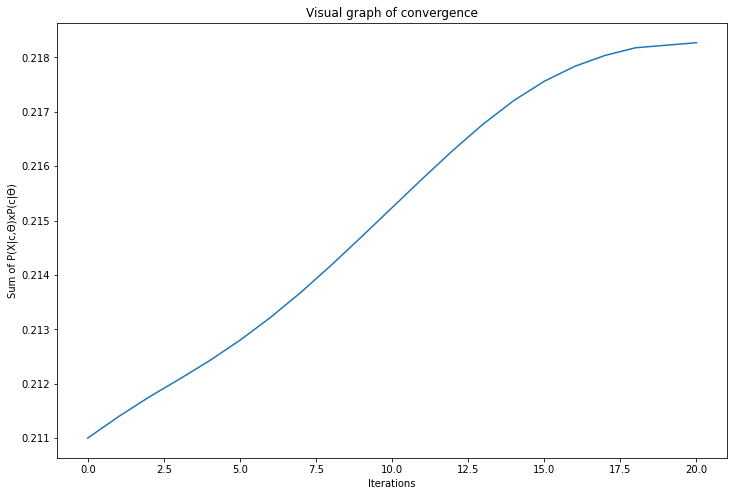

In [3]:
#The function provided in CS342 website to draw ellipses
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

#These are the inital values for EM algorithm which was predicted using kmean
def initialize_random_params():
    params = {'pi0': x_y[relabel==0].shape[0]/x_y.shape[0],
              'pi1': x_y[relabel==1].shape[0]/x_y.shape[0],
              'pi2': x_y[relabel==2].shape[0]/x_y.shape[0],
              'mu0': recenters[0],
              'mu1': recenters[1],
              'mu2': recenters[2],
              'sigma0': np.cov(x_y[relabel == 0].T, bias= True),
              'sigma1': np.cov(x_y[relabel == 1].T, bias= True),
              'sigma2': np.cov(x_y[relabel == 2].T, bias= True)}
    return params

#E step of the algorithm
def E(x,params):
    pdf0 = multivariate_normal(params["mu0"], params["sigma0"]).pdf(x)*params["pi0"]
    pdf1 = multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)*params["pi1"]
    pdf2 = multivariate_normal(params["mu2"], params["sigma2"]).pdf(x)*params["pi2"]
    pdf = np.array([pdf0,pdf1,pdf2])
    norm = np.sum(pdf,axis=0)
    return norm,np.divide(pdf,norm).T

#M step of the algorithm
def M(x, params):
    n = x.shape[0]
    r = E(x, params)[1]
    pi = np.array([])
    for i in range(3):
        pi = np.append(pi,np.sum(r[:,i])/n)
    mu0 = (r[:, 0].T.dot(x)/np.sum(r[:, 0]))
    mu1 = (r[:, 1].T.dot(x)/np.sum(r[:, 1]))
    mu2 = (r[:, 2].T.dot(x)/np.sum(r[:, 2]))
    sigma0 = (x - mu0).T.dot((x - mu0) * r[:, 0][:, np.newaxis]) / np.sum(r[:, 0])
    sigma1 = (x - mu1).T.dot((x - mu1) * r[:, 1][:, np.newaxis]) / np.sum(r[:, 1])
    sigma2 = (x - mu2).T.dot((x - mu2) * r[:, 2][:, np.newaxis]) / np.sum(r[:, 2])
    params = {'pi0':pi[0],'pi1':pi[1],'pi2':pi[2],'mu0':mu0,'mu1':mu1,'mu2':mu2,'sigma0':sigma0,'sigma1':sigma1,\
              'sigma2':sigma2}
    return params

#This function combines the E and M steps and loops it until it converges with a difference lower than 'tolerance'
def EM(x, params, tolerance):
    iteration = np.array([])
    i = 0
    while (i == 0):
        norm = np.mean(E(x, params)[0])
        iteration = np.append(iteration, norm)
        if len(iteration) > 2:
            if abs(iteration[-1] - iteration[-2]) < tolerance:
                i+=1
        params = M(x_y, params)
    print("pi0: %s\npi1: %s\npi2: %s\nmu_0: %s\nmu_1: %s\nmu_2: %s\nsigma_0:\n %s\nsigma_1:\n %s\nsigma_2:\n %s"
               % (params['pi0'], params['pi1'], params['pi2'], params['mu0'], params['mu1'], params['mu2'],\
                  params['sigma0'], params['sigma1'], params['sigma2']))
    r = E(x_y, params)[1]
    predicted = np.argmax(r, axis=1)
    return predicted, r, iteration, params

#Intialising the parameters and running the EM function
initial_paras = initialize_random_params()
predicted, r, steps,params = EM(x_y, initial_paras, 0.0001)
print("total steps: ", len(steps))

#Plot the convergence of EM algorithm
x = np.linspace(0, len(steps), len(steps)).astype(int)
ax = plt.figure(figsize=(12,8))
plt.plot(x, steps)
plt.title("Visual graph of convergence")
plt.xlabel('Iterations')
plt.ylabel('Sum of P(X|c,\u03F4)xP(c|\u03F4)')
plt.show()

The accuracy for EM algorithm is 98.0 %


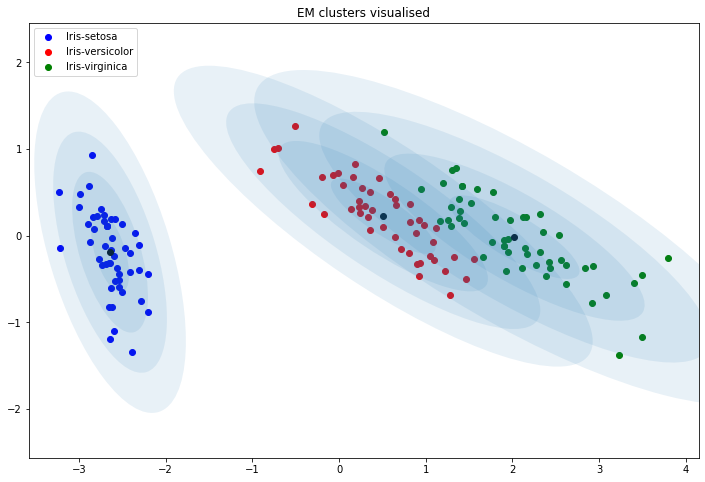

In [4]:
#Score assigned to work out the accuracy of EM algorithm compared to the ground truth
score = 0
for i in range(len(y_number)):
    if y_number[i] == predicted[i]:
        score+=1
print('The accuracy for EM algorithm is',100*score/150,'%')

#Plot all the points with it's predicted cluster assignment
plt.figure(figsize=(12,8))
for i in range(len(predicted)):
    if predicted[i] == 0:
        versicolor = plt.scatter(x_y[i,0],x_y[i,1],c='r')
    if predicted[i] == 1:
        virginica = plt.scatter(x_y[i,0],x_y[i,1],c='g')
    if predicted[i] == 2:
        setosa = plt.scatter(x_y[i,0],x_y[i,1],c='b')

#Get the ellipse's centers and covariance from parameters and plot ellipses
ellipse_centers = np.array([params['mu0'],params['mu1'],params['mu2']])
covariance = np.array([params['sigma0'],params['sigma1'],params['sigma2']])
bx = plt.scatter(ellipse_centers[:,0],ellipse_centers[:,1],c='k')
bx = plt.axis('equal')
bx = plt.gca()
for i in range(0,3):
    draw_ellipse(ellipse_centers[i],covariance[i],alpha=1/10)
    
plt.legend((setosa,versicolor,virginica),(train_target.unique()))
plt.title("EM clusters visualised")
plt.show()